# Deep Neural Network for Image Classification


This is another example of image processing for deep neural network. In the previous example we made a simple model by Logistic Regression as a Neural Network with 70 percent accuracy. Know we want to improve the model.
This is a classification problem with a result of cat and non-cat images.


# Two possible models
1- A 2-layer neural network  
2- An L-Layer deep neural network




At the first part,  we will write a code which is composed of  2 hidden layers. At the first layer we have used the RELU activation function and at the seccond layer  we used the Sigmoid to produce the classification results. Then we expand this code to L number of hidden layers. We want to see does accucy increases by increasing of the number of layers or not?  




In [95]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import skimage
from dnn_app_utils_v2 import *

In [96]:
# loading of an h5 dataset
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")

list(train_dataset.keys())

['list_classes', 'train_set_x', 'train_set_y']

In [97]:
# extracting of  train, test and classes
train_set_x = np.array(train_dataset["train_set_x"][:]) 
train_set_y = np.array(train_dataset["train_set_y"][:])
test_set_x = np.array(test_dataset["test_set_x"][:]) 
test_set_y = np.array(test_dataset["test_set_y"][:]) 
classes = np.array(test_dataset["list_classes"][:])
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [98]:
print(train_set_x.shape)
print(train_set_y.shape)

(209, 64, 64, 3)
(209,)


y = 1. It's a cat picture.


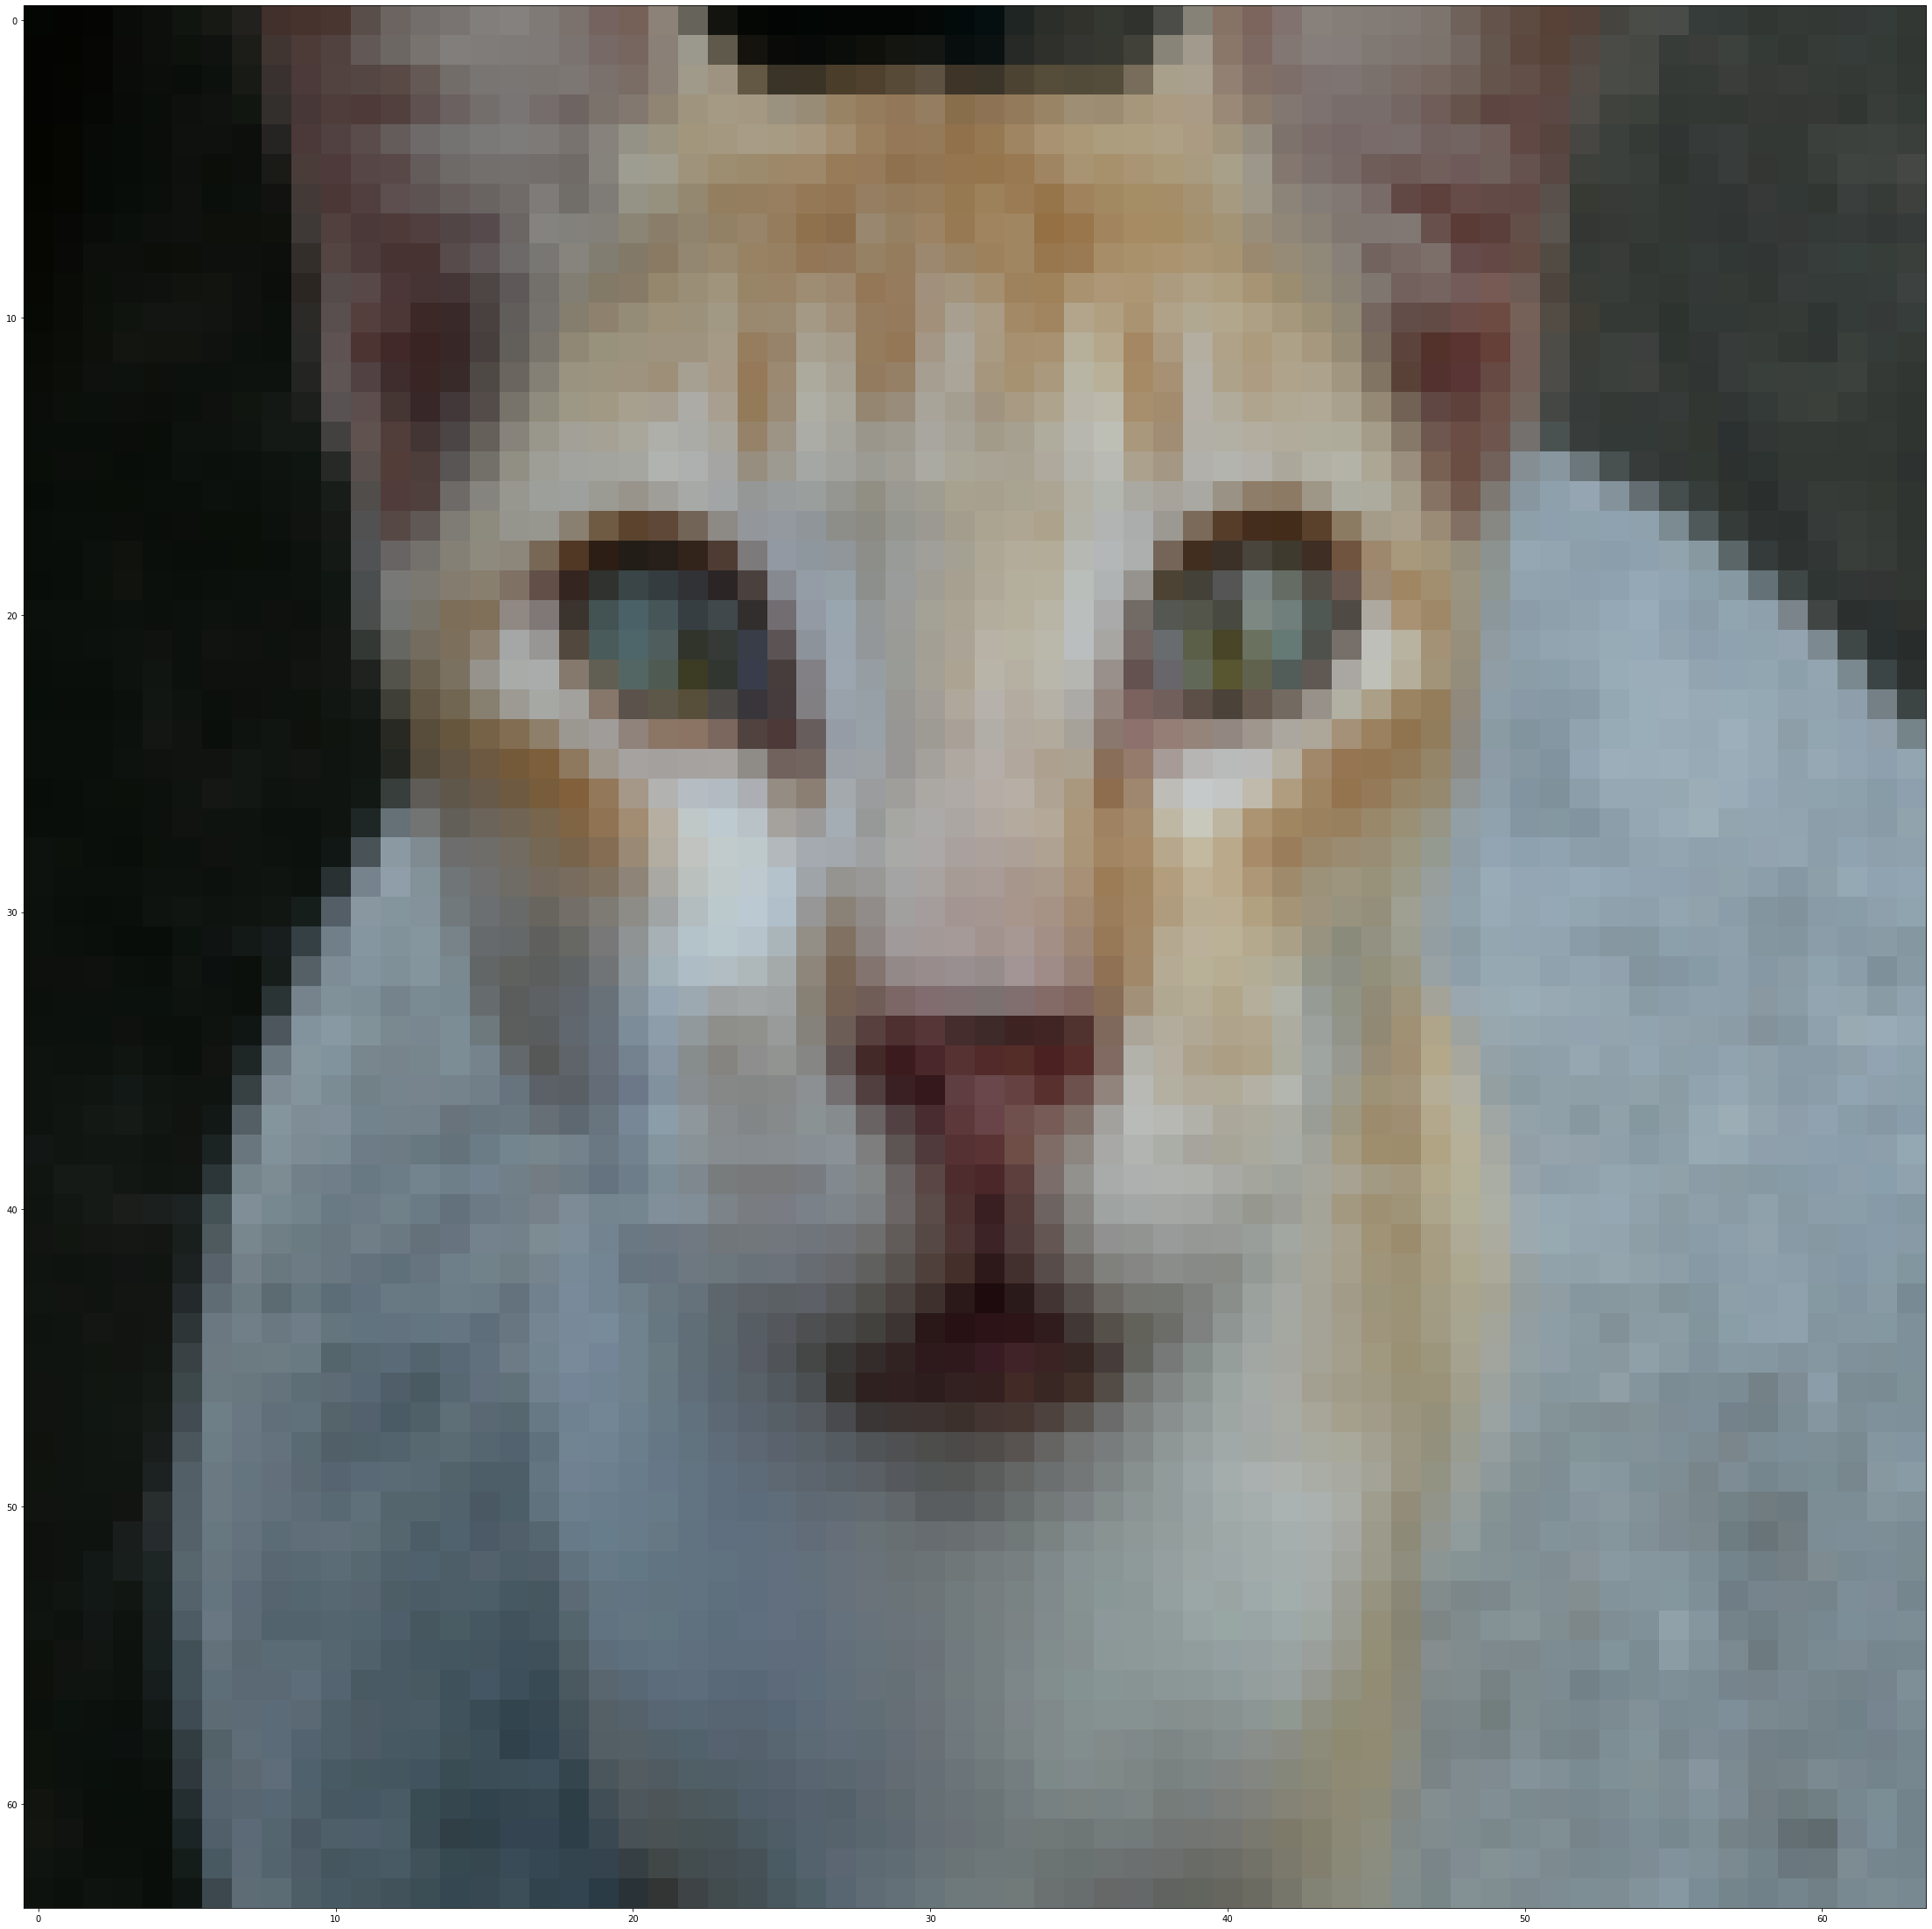

In [103]:
index = 11
plt.imshow(train_set_x[index])
print ("y = " + str(train_set_y[index]) + ". It's a " + classes[train_set_y[index]].decode("utf-8") +  " picture.")

In [6]:
# transfer to the array
train_set_x=train_set_x.reshape(train_set_x.shape[0],-1).T
test_set_x=test_set_x.reshape(test_set_x.shape[0],-1).T


# transfer a (209,) array to the (1,209) array
# should be run one time
train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))


In [7]:
train_set_x = train_set_x/255.
test_set_x = test_set_x/255.

In [8]:
print(train_set_x.shape)
print(train_set_y.shape)

(12288, 209)
(1, 209)


##  2-layer neural network

Layer1 (12288, 209) -LINEAR -RELU-LINEAR-SIGMOID- Layer2 (1,209) Output


Layer1 (12288, 209)  - Layer2 to Layern () - Output

In [9]:
x = np.array([[1,-2],[3,-4]])
y= relu(x)
print(y)

(array([[1, 0],
       [3, 0]]), array([[ 1, -2],
       [ 3, -4]]))


### Initializing parameters

In [80]:
# Define the sigmoid function
def sig(z):
    
    a = 1./(1+np.exp(-z))
    cache =  z          
    return a, cache
#---------------------------------------------------------


# Define the relu function (get z matrix and return a)
def relu(z):
    
    a = np.maximum(0,z)
    assert(a.shape == z.shape)
    cache =  z
    return a, cache

#---------------------------------------------------------

# get the da matrix and return the az
def relu_back(da, cache):
    
    z = cache 
    dz = np.array(da, copy=True) # just converting dz to a correct object.
    dz[z <= 0] = 0
    cache =  z
    return dz


#---------------------------------------------------------
# Define the sigmoid backward: dz[i]= A[i] -Y  , A[i]=sig(z[i])
def sig_back(da,cache):
    
    z = cache
    s = 1./(1 + np.exp(-z))
    dz = da *s* (1-s)
    
    assert (dz.shape == z.shape)
    
    return dz
#---------------------------------------------------------

# Initializing parameters
def layer_sizes(X, Y):
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h, n_y)

#---------------------------------------------------------
# Define w and b functions
def initial_wb(n_x, n_h, n_y):
    
    np.random.seed(1)
    w1 = np.random.randn(n_h,n_x) * 0.01
    w2 = np.random.randn(n_y,n_h) * 0.01
    b1 = np.zeros((n_h, 1))
    b2 = np.zeros((n_y, 1))
    
    param_wb = {"w1": w1,"w2": w2,
             "b1": b1, "b2": b2}       
    return param_wb

#-------------------------------------------------------------

def initial_wb_deep(layer_dims):
   #  layer_dims -- python array (list) containing the dimensions of each layer in our network

    np.random.seed(1)
    param_wb = {}
    L = len(layer_dims)            # number of layers in the network
    
    for l in range(1, L):
        param_wb['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        param_wb['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(param_wb['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(param_wb['b' + str(l)].shape == (layer_dims[l], 1))

        
    return param_wb
    
#-------------------------------------------------------------
def initialize_parameters_deep(layer_dims):
    
    np.random.seed(1)
    param_wb = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        param_wb['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        param_wb['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(param_wb['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(param_wb['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

#-------------------------------------------------------------


# Define w and b functions
def linear_forward(a,w,b):
    z = w.dot(a)+b
    #print(z.shape)
    #print(a.shape)
    assert(z.shape == (w.shape[0],a.shape[1]))
    cache = (a, w, b)   
    return z, cache


#-----------------------------------------------------------
    
def linear_activation_forward(a_prev, w, b, activation): 
    if activation == "sigmoid":
        z, linear_cache = linear_forward(a_prev, w, b)
        a, activation_cache = sig(z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        z, linear_cache = linear_forward(a_prev, w, b)
        a, activation_cache = relu(z)
    
    assert (a.shape == (w.shape[0], a_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return a, cache



    
#-------------------------------------------------------------   
#Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
#In this case we have L number of hidden layers


def L_model_forward(X, param_wb):
    
    cache_list = []
    a = X   #at the begining our a starts from the x
    L = len(param_wb) //2   #param_wb contains w_i and b_i, so we should devide it by 2

    
    #This is [LINEAR -> RELU]*(L-1)  with activation of relu
    for l in range(1,L): 
        a_prev =  a
        a, cache = linear_activation_forward(a_prev,  param_wb['w'+ str(l)], param_wb['b'+ str(l)], activation= "relu")
        cache_list.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list
    a_last, cache = linear_activation_forward(a, param_wb['w'+ str(L)], param_wb['b'+ str(L)], activation='sigmoid')
    cache_list.append(cache)
    
    
    assert(a_last.shape  == (1, X.shape[1]))
    
    return a_last, cache_list


# ------------------------------------------------------------     
    



def cost_funk(y, a_last):
    
   
    m = y.shape[1] # number of example
    
    cost = -1./m * np.sum((y*np.log(a_last) + (1 - y)*np.log(1- a_last)))
    cost = np.squeeze(cost)  # makes sure cost is the dimension we expect.
    assert(cost.shape == ())
    
    return cost


#------------------------------------------------------------

# For the backward propagation we need to calculate dw, db and dz.
# This code calculates the dw and db. They are the same in the final sig layer and middle relu layers.
def linear_backward(dz, cache):
    
    a_prev, w, b = cache
    
    m = a_prev.shape[1]
    dw = (1/m) * (np.dot(dz, a_prev.T))
    db = (1/m) * np.sum(dz, axis=1, keepdims=True)
    da_prev = np.dot(w.T,dz)
    
    assert (da_prev.shape == a_prev.shape)
    assert (dw.shape == w.shape)
    assert (db.shape == b.shape)
    
    return da_prev, dw, db   
#------------------------------------------------------------

# we need to calculate dz. dz for the final sig layer is dz=A-Y and for the middle layer is dz=w.T *dz * g'(z1)
def linear_activation_backward(da, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dz = relu_back(da, activation_cache)
        da_prev, dw, db = linear_backward(dz, linear_cache)
        
    elif activation == "sigmoid":
        dz = sig_back(da, activation_cache)
        da_prev, dw, db = linear_backward(dz, linear_cache)
    
    return da_prev, dw, db
#------------------------------------------------------------

def L_model_backward(a_last, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = a_last.shape[1]
    Y = Y.reshape(a_last.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    da_last = - (np.divide(Y, a_last) - np.divide(1 - Y, 1 - a_last))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "a_last, Y, caches". Outputs: "grads[""], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["da" + str(L)], grads["dw" + str(L)], grads["db" + str(L)] = linear_activation_backward(da_last, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        da_prev_temp, dw_temp, db_temp = linear_activation_backward(grads["da" + str(l + 2)], current_cache, activation = "relu")
        grads["da" + str(l + 1)] = da_prev_temp
        grads["dw" + str(l + 1)] = dw_temp
        grads["db" + str(l + 1)] = db_temp

    return grads
#----------------------------------------------------------

def update_parameters(param_wb, grads, learning_rate):
    
    L = len(param_wb) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        param_wb["w" + str(l+1)] = param_wb["w" + str(l+1)] - learning_rate * grads["dw" + str(l+1)]
        param_wb["b" + str(l+1)] = param_wb["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return param_wb



#-----------------------------------------------------------
def predict(X, y, param_wb):
 
    m = X.shape[1]
    n = len(param_wb) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    a_last, caches = L_model_forward(X, param_wb)

    
    # convert probas to 0/1 predictions
    for i in range(0, a_last.shape[1]):
        if a_last[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

#-----------------------------------------------------------
def print_mislabeled_images(classes, X, y, p):

    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))





In [81]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [67]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    param_wb = initial_wb(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    w1 = param_wb["w1"]
    b1 = param_wb["b1"]
    w2 = param_wb["w2"]
    b2 = param_wb["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        a1, cache1 = linear_activation_forward(X, w1, b1, activation='relu')
        a2, cache2 = linear_activation_forward(a1, w2, b2, activation='sigmoid')
        
        # Compute cost
        cost = compute_cost(a2, Y)
        
        # Initializing backward propagation
        da2 = - (np.divide(Y, a2) - np.divide(1 - Y, 1 - a2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        da1, dw2, db2 = linear_activation_backward(da2, cache2, activation='sigmoid')
        da0, dw1, db1 = linear_activation_backward(da1, cache1, activation='relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dw1'] = dw1
        grads['db1'] = db1
        grads['dw2'] = dw2
        grads['db2'] = db2
        
        # Update parameters.
        param_wb = update_parameters(param_wb, grads, learning_rate=learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        w1 = param_wb["w1"]
        b1 = param_wb["b1"]
        w2 = param_wb["w2"]
        b2 = param_wb["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return param_wb

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912678
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764731
Cost after iteration 600: 0.4754901313943325
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213016
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466116
Cost after iteration 1500: 0.17448318112556607
Cost after iteration 1600: 0.17080762978095848
Cost after iteration 1700: 0.11306524562164755
Cost after iteration 1800: 0.0962942684593717
Cost after iteration 1900: 0.08342617959726872
Cost after iteration 2000: 0.0743907870431909
Cost after iteration 2100: 0.0663074813

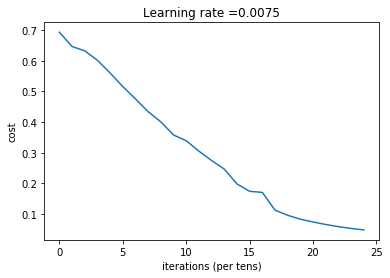

In [44]:
parameters = two_layer_model(train_set_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [87]:
pred_train = predict(train_set_x, train_set_y, parameters)

Accuracy: 0.9999999999999998


In [47]:
predictions_test = predict(test_set_x, test_set_y, parameters)


Accuracy: 0.72


## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [90]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model


In [91]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009


    np.random.seed(1)
    costs = []                         # keep track of cost

    param_wb = initialize_parameters_deep(layers_dims)
  
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        aL, caches = L_model_forward(X, param_wb)
        
        # Compute cost.
        cost = compute_cost(aL, Y)
    
        # Backward propagation.
        grads = L_model_backward(aL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(param_wb, grads, learning_rate=learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.008372
Cost after iteration 100: 0.008049
Cost after iteration 200: 0.007743
Cost after iteration 300: 0.007461
Cost after iteration 400: 0.007193
Cost after iteration 500: 0.006943
Cost after iteration 600: 0.006712
Cost after iteration 700: 0.006491
Cost after iteration 800: 0.006283
Cost after iteration 900: 0.006085
Cost after iteration 1000: 0.005900
Cost after iteration 1100: 0.005724
Cost after iteration 1200: 0.005557
Cost after iteration 1300: 0.005398
Cost after iteration 1400: 0.005247
Cost after iteration 1500: 0.005105
Cost after iteration 1600: 0.004969
Cost after iteration 1700: 0.004838
Cost after iteration 1800: 0.004713
Cost after iteration 1900: 0.004598
Cost after iteration 2000: 0.004482
Cost after iteration 2100: 0.004373
Cost after iteration 2200: 0.004271
Cost after iteration 2300: 0.004170
Cost after iteration 2400: 0.004075


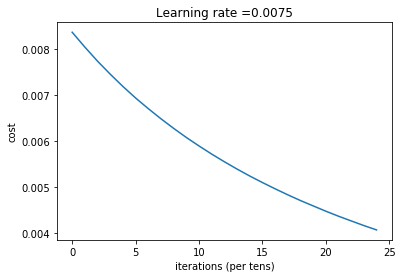

In [92]:
parameters = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 2500, print_cost = True)

In [86]:
pred_train = predict(train_set_x, train_set_y, parameters)

Accuracy: 0.9999999999999998


In [88]:
pred_test = predict(test_set_x, test_set_y, parameters)

Accuracy: 0.7000000000000001


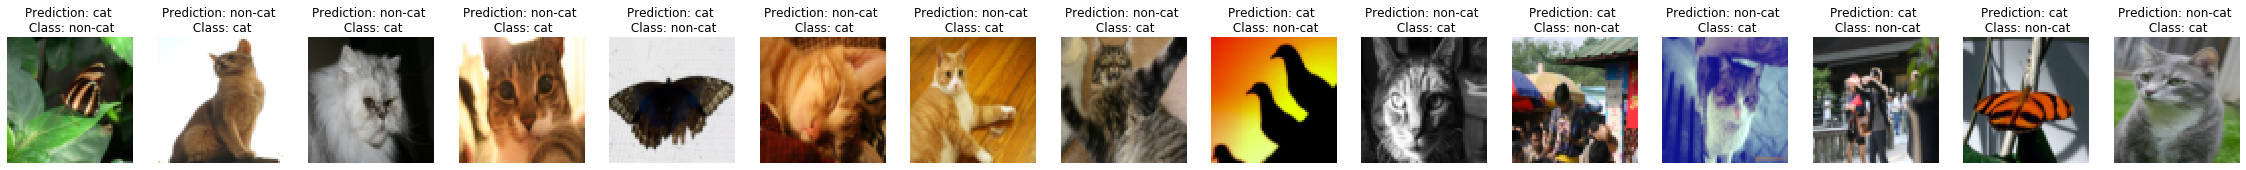

In [93]:
print_mislabeled_images(classes, test_set_x, test_set_y, pred_test)

### Reasons that  pictures did not recognized correctly in our systems:

1. The body of the animal is so small
2. Animal and backgroud has the same color
3. position of the animal or color is unusuall
4. Brighness of the picture
